# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
pd.set_option('display.max_colwidth', 100)

# Code to unzip files and store in Data folder

import zipfile

zip_file_path = 'Data/belt-exam-aml-mock-exam.zip'
extract_folder = 'Data/'

# Create the 'Data' folder if it dosen't exist
os.makedirs(extract_folder,exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Loading Data

In [2]:
path = 'Data/data/part1-aml-belt-exam.csv'
df= pd.read_csv(path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27573 entries, 0 to 27572
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source     27573 non-null  object
 1   paragraph  27573 non-null  object
dtypes: object(2)
memory usage: 431.0+ KB


,source,paragraph
0,Christie,"thought to be an Englishman, but they never got any clue as to his"
1,Christie,“Who?” The word came faintly between her parted lips.
2,Christie,"“Doesn’t sound likely to me,” said the inspector. “But—well, can"
3,Christie,The coincidence was rather startling. Could it be possible that
4,Christie,"The thing seemed simple enough, but Pagett is a person who loves"


# Checking Value counts

In [4]:
df.source.value_counts(dropna=False)

Conan Doyle    15016
Christie       12557
Name: source, dtype: int64

# Import spacy and load 'en_core_web_sm'
- disable parser and ner

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
nlp.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

# Custom Functions

In [6]:
# Load the autoreload extension
# This is to be able to change our functions while using
%load_ext autoreload
%autoreload 2

import custom_functions as fn

# Making new columns for tokens and lemmas

In [7]:
# Using custom function to produce tokens with nlp arugments
df['tokens'] = fn.batch_preprocess_texts(df.paragraph,nlp=nlp)
# Using custom function to produce lemmas with nlp arguments
df['lemmas'] = fn.batch_preprocess_texts(df.paragraph,nlp=nlp)
df.head()

27573it [00:16, 1672.91it/s]


,source,paragraph,tokens
0,Christie,"thought to be an Englishman, but they never got any clue as to his","[thought, englishman, got, clue]"
1,Christie,“Who?” The word came faintly between her parted lips.,"[word, came, faintly, parted, lips]"
2,Christie,"“Doesn’t sound likely to me,” said the inspector. “But—well, can","[sound, likely, said, inspector]"
3,Christie,The coincidence was rather startling. Could it be possible that,"[coincidence, startling, possible]"
4,Christie,"The thing seemed simple enough, but Pagett is a person who loves","[thing, simple, pagett, person, loves]"


# Create new column for joined tokens and lemmas

In [10]:
# Join list of tokens into a sting with spaces between each token
df['tokens_joined'] = df.tokens.map(lambda x: ' '.join(x))
# Join list of lemmas inot a string with spaces between each lemmas
df['lemmas_joined'] = df.lemmas.map(lambda x: ' '.join(x))
df.head()

,source,paragraph,tokens,lemmas,tokens_joined,lemmas_joined
0,Christie,"thought to be an Englishman, but they never got any clue as to his","[thought, englishman, got, clue]","[thought, englishman, got, clue]",thought englishman got clue,thought englishman got clue
1,Christie,“Who?” The word came faintly between her parted lips.,"[word, came, faintly, parted, lips]","[word, came, faintly, parted, lips]",word came faintly parted lips,word came faintly parted lips
2,Christie,"“Doesn’t sound likely to me,” said the inspector. “But—well, can","[sound, likely, said, inspector]","[sound, likely, said, inspector]",sound likely said inspector,sound likely said inspector
3,Christie,The coincidence was rather startling. Could it be possible that,"[coincidence, startling, possible]","[coincidence, startling, possible]",coincidence startling possible,coincidence startling possible
4,Christie,"The thing seemed simple enough, but Pagett is a person who loves","[thing, simple, pagett, person, loves]","[thing, simple, pagett, person, loves]",thing simple pagett person loves,thing simple pagett person loves


# Create filter to seperating authors Conan Doyle and Christie 

In [15]:
# Creating filters
conan_doyle = df['source']=='Conan Doyle'
christie = df['source']=='Christie'
conan_doyle.sum(), christie.sum()

(15016, 12557)

# Word Cloud
- Import wordcloud
- Need to combine tokens into a single string

In [23]:
from wordcloud import WordCloud
# Using .join to join tokens_joined and .loc to slice author's tokens
conan_doyle_text = ' '.join(df.loc[conan_doyle, 'tokens_joined'])
christie_text = ' '.join(df.loc[christie, 'tokens_joined'])
print(christie_text[:100],"\n")

thought englishman got clue word came faintly parted lips sound likely said inspector coincidence st 



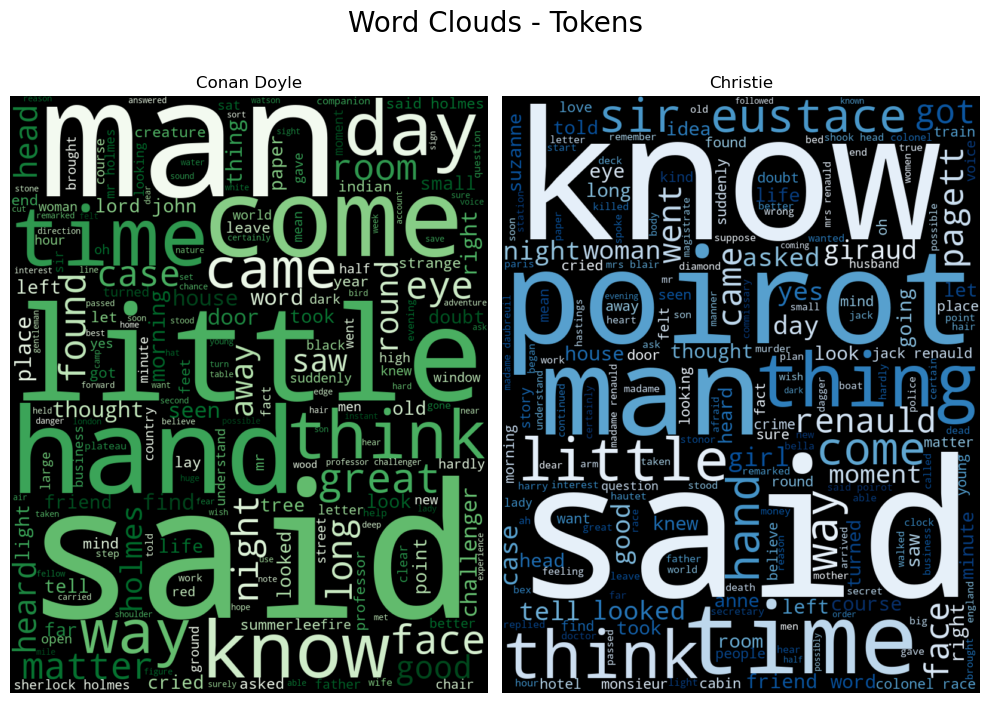

In [28]:
# Make word clouds of processed joined_tokens
# Create an instance of a WordCloud and use the generate method
conan_cloud = WordCloud(random_state=42, width = 800, height = 1000,
                       min_word_length = 2, colormap = 'Greens').generate(conan_doyle_text)
christie_cloud = WordCloud(random_state = 42, width = 800, height = 1000, 
                          min_word_length = 2, colormap = 'Blues').generate(christie_text)
# Plot the wordcloud side by side
fig,axes = plt.subplots(ncols=2, figsize=(10,7))
axes[0].imshow(conan_cloud, interpolation = 'bilinear')
axes[0].set_title('Conan Doyle')
axes[1].imshow(christie_cloud, interpolation = 'bilinear')
axes[1].set_title('Christie')
[ax.axis('off') for ax in axes]
fig.tight_layout()
fig.suptitle('Word Clouds - Tokens', fontsize=20, y = 1.05);

# N Grams

In [29]:
conan_doyle_text_split = conan_doyle_text.split()
christie_text_split = christie_text.split()
christie_text_split[0:5]

['thought', 'englishman', 'got', 'clue', 'word']

In [33]:
conan_doyle_text_exploded_list = df.loc[conan_doyle, 'tokens'].explode().astype(str).to_list()
conan_doyle_text_exploded_list[:5]

['block', 'house', 'whitewashed', 'stained', 'streaked']

In [34]:
christie_text_exploded_list = df.loc[christie, 'tokens'].explode().astype(str).to_list()
christie_text_exploded_list[:5]

['thought', 'englishman', 'got', 'clue', 'word']

# Import nltk for bigrams

In [35]:
import nltk

#instantiate a measure objects for Bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [38]:
# Create a finder for the author's reviews
bigram_finder_conan = nltk.BigramCollocationFinder.from_words(conan_doyle_text_exploded_list)

# Obtain scores for the bigrams using the score_ngrams method
# Include the desired scoring method of the measures object
bigrams_socre_conan = bigram_finder_conan.score_ngrams(bigram_measures.raw_freq)
bigrams_socre_conan[:10]

[(('lord', 'john'), 0.0018409319718107292),
 (('said', 'holmes'), 0.00152452178915576),
 (('sherlock', 'holmes'), 0.0012800230116496475),
 (('mr.', 'holmes'), 0.0009779951100244498),
 (('professor', 'challenger'), 0.0009204659859053646),
 (('said', 'i.'), 0.0005465266791313102),
 (('ape', 'men'), 0.000532144398101539),
 (('st.', 'simon'), 0.0005033798360419962),
 (('professor', 'summerlee'), 0.00043146843089313965),
 (('said', 'lord'), 0.00041708614986336835)]

In [39]:
# Create a finder for author's reviews
bigram_finder_christie = nltk.BigramCollocationFinder.from_words(christie_text_exploded_list)

# Obtain scores for the bigrams using the socre_ngrams method
# Include the desired scoring method of the measures object
bigram_socre_christie = bigram_finder_christie.score_ngrams(bigram_measures.raw_freq)
bigram_socre_christie[:10]

[(('sir', 'eustace'), 0.0037363514346864003),
 (('m.', 'renauld'), 0.0019225886023143614),
 (('jack', 'renauld'), 0.0017774875757245983),
 (('colonel', 'race'), 0.0016867994341059963),
 (('said', 'poirot'), 0.0012514963543367068),
 (('mrs.', 'blair'), 0.0011789458410418254),
 (('shook', 'head'), 0.0011426705843943846),
 (('m.', 'hautet'), 0.0011245329560706642),
 (('madame', 'daubreuil'), 0.001070120071099503),
 (('mrs.', 'renauld'), 0.0009794319294809011)]

In [40]:
# Convert list of tuples to dataframe
df_bigram_socre_conan = pd.DataFrame(bigrams_socre_conan, columns = ['Words', 'Frequency'])
df_bigram_socre_conan.head()

,Words,Frequency
0,"(lord, john)",0.001841
1,"(said, holmes)",0.001525
2,"(sherlock, holmes)",0.001280
3,"(mr., holmes)",0.000978
4,"(professor, challenger)",0.000920


In [45]:
# Convert the list of tuples to dataframe
df_bigram_score_christie = pd.DataFrame(bigram_socre_christie, columns = ['Words', 'Frequency'])
df_bigram_score_christie.head()

,Words,Frequency
0,"(sir, eustace)",0.003736
1,"(m., renauld)",0.001923
2,"(jack, renauld)",0.001777
3,"(colonel, race)",0.001687
4,"(said, poirot)",0.001251


In [46]:
# Combine both groups and add a group name as mulit-index
df_compare_bigrams_freq = pd.concat([df_bigram_socre_conan,df_bigram_score_christie], 
                                    axis = 1, keys = ['Conan Rating Reiews', 'Christie Rating Reiews'])
df_compare_bigrams_freq.head(20)

Conan Rating Reiews             Christie Rating Reiews          
                      Words Frequency                    Words Frequency
0              (lord, john)  0.001841           (sir, eustace)  0.003736
1            (said, holmes)  0.001525            (m., renauld)  0.001923
2        (sherlock, holmes)  0.001280          (jack, renauld)  0.001777
3             (mr., holmes)  0.000978          (colonel, race)  0.001687
4   (professor, challenger)  0.000920           (said, poirot)  0.001251
5                (said, i.)  0.000547            (mrs., blair)  0.001179
6                (ape, men)  0.000532            (shook, head)  0.001143
7              (st., simon)  0.000503             (m., hautet)  0.001125
8    (professor, summerlee)  0.000431      (madame, daubreuil)  0.001070
9              (said, lord)  0.000417          (mrs., renauld)  0.000979
10              (lord, st.)  0.000403        (madame, renauld)  0.000871
11           (john, roxton)  0.000374               (mon, ami)  0.000744
12          (baker, street)  0.000360                 (m., le)  0.000653
13             (st., clair)  0.000345               (le, juge)  0.000617
14           (maple, white)  0.000331  (examining, magistrate)  0.000580
15          (young, fellah)  0.000331        (miss, pettigrew)  0.000562
16            (red, headed)  0.000316       (georges, conneau)  0.000544
17       (said, challenger)  0.000316      (marthe, daubreuil)  0.000544
18            (young, lady)  0.000302      (miss, beddingfeld)  0.000544
19             (young, man)  0.000288             (young, man)  0.000544

In [47]:
# Use function to find frequency values for quad-grams in low reviews
fn.get_ngram_measures_finder(conan_doyle_text_exploded_list, ngrams=2, top_n=20)

,Words,Raw Freq
0,"(lord, john)",0.001841
1,"(said, holmes)",0.001525
2,"(sherlock, holmes)",0.001280
3,"(mr., holmes)",0.000978
4,"(professor, challenger)",0.000920
5,"(said, i.)",0.000547
6,"(ape, men)",0.000532
7,"(st., simon)",0.000503
8,"(professor, summerlee)",0.000431
9,"(said, lord)",0.000417


In [48]:
# Use function to find frequency values for quad-grams in low reviews
fn.get_ngram_measures_finder(christie_text_exploded_list, ngrams=2, top_n=20)

,Words,Raw Freq
0,"(sir, eustace)",0.003736
1,"(m., renauld)",0.001923
2,"(jack, renauld)",0.001777
3,"(colonel, race)",0.001687
4,"(said, poirot)",0.001251
5,"(mrs., blair)",0.001179
6,"(shook, head)",0.001143
7,"(m., hautet)",0.001125
8,"(madame, daubreuil)",0.001070
9,"(mrs., renauld)",0.000979
